# Valores missing, outliers y correlaciones

Vamos a realizar el preprocesamiento de las variables númericas y categóricas. Los pasos a seguir son los siguientes:

1. Cambiamos el tipo de variables.
2. Separamos en train y test.
3. Realizamos gráficos para analizar cada variable.
4. Identificación de missing y outliers.
5. Con las variables continuas realizamos un estudio de la correlación con el método pearson.
6. Con las variables categóricas estudiamos la correlación con vCramer.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import scipy.stats as ss
import warnings
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df, x=col_name, color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0


def get_deviation_of_mean_perc(df, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = df[i].mean()
        series_std = df[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = df[i].size
        
        perc_goods = df[i][(df[i] >= left) & (df[i] <= right)].size/size_s
        perc_excess = df[i][(df[i] < left) | (df[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(df[target][(df[i] < left) | (df[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('fraud_bool',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = df[i][(df[i] < left) | (df[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def get_percent_null_values_target(df, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if df[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(df[target][df[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = df[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = df[i].isnull().sum()/df.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

Leemos el CSV con el dataframe con el que terminamos el Notebook1.

In [3]:
pd_fraud_filter_null = pd.read_csv("../data/pd_data_initial_preprocessing.csv")

In [4]:
pd_fraud_filter_null

,Unnamed: 0,fraud_bool,income,device_fraud_count,device_distinct_emails_8w,keep_alive_session,device_os,session_length_in_minutes,source,foreign_request,proposed_credit_limit,has_other_cards,bank_months_count,phone_mobile_valid,phone_home_valid,housing_status,email_is_free,credit_risk_score,employment_status,date_of_birth_distinct_emails_4w,bank_branch_count_8w,velocity_4w,velocity_24h,velocity_6h,zip_count_4w,payment_type,intended_balcon_amount,days_since_request,customer_age,current_address_months_count,prev_address_months_count,name_email_similarity,month
0,0,1,0.9,0,1,0,windows,3.888115,INTERNET,0,500.0,0,24,0,1,BA,0,185,CA,6,1,3863.647740,3134.319630,10650.765523,769,AA,-1.331345,0.020925,50,88,-1,0.166828,7
1,1,1,0.9,0,1,0,windows,31.798819,INTERNET,0,1500.0,0,15,0,0,BA,1,259,CA,3,718,3124.298166,2670.918292,534.047319,366,AB,-0.816224,0.005418,50,144,-1,0.296286,7
2,2,1,0.9,0,1,0,other,4.728705,INTERNET,0,200.0,0,-1,1,0,BA,1,177,CB,14,1,3159.590679,2893.621498,4048.534263,870,AC,-0.755728,3.108549,40,132,-1,0.044985,7
3,3,1,0.9,0,1,0,linux,2.047904,INTERNET,0,200.0,1,31,1,0,BA,1,110,CA,6,1921,3022.261812,4054.908412,3457.064063,810,AB,-1.205124,0.019079,50,22,-1,0.159511,7
4,4,1,0.9,0,1,1,macintosh,3.775225,INTERNET,0,1500.0,0,31,0,1,BA,1,295,CA,2,1990,3087.670952,2728.237159,5020.341679,890,AB,-0.773276,0.004441,50,218,-1,0.596414,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,0,0.6,0,1,1,linux,8.511502,INTERNET,0,200.0,0,25,1,1,BC,1,75,CA,8,1,4972.635997,8341.468557,7905.711839,804,AB,-1.044454,0.030592,40,104,-1,0.192631,4
999996,999996,0,0.8,0,1,0,windows,8.967865,INTERNET,0,200.0,0,-1,1,1,BC,1,154,CC,2,0,5022.728108,4955.170808,5391.470463,3306,AC,-1.409803,1.628119,50,9,148,0.322989,4
999997,999997,0,0.8,0,1,0,other,8.195531,INTERNET,0,200.0,0,11,1,0,BC,0,64,CF,6,2023,4377.196321,5670.654316,8063.102636,1522,AA,34.692760,0.018563,20,30,-1,0.879403,4
999998,999998,0,0.9,0,1,1,windows,4.336064,INTERNET,0,500.0,0,28,0,1,BA,0,163,CA,6,1678,4394.803296,3982.582204,8092.641762,1418,AA,94.661055,0.015352,20,189,-1,0.762112,4


Observamos que se nos creó la columna "Unnamed: 0" y por lo tanto procedemos a borrarla.

In [5]:
pd_fraud_filter_null = pd_fraud_filter_null.drop(columns=["Unnamed: 0"])

In [6]:
pd_fraud_filter_null

,fraud_bool,income,device_fraud_count,device_distinct_emails_8w,keep_alive_session,device_os,session_length_in_minutes,source,foreign_request,proposed_credit_limit,has_other_cards,bank_months_count,phone_mobile_valid,phone_home_valid,housing_status,email_is_free,credit_risk_score,employment_status,date_of_birth_distinct_emails_4w,bank_branch_count_8w,velocity_4w,velocity_24h,velocity_6h,zip_count_4w,payment_type,intended_balcon_amount,days_since_request,customer_age,current_address_months_count,prev_address_months_count,name_email_similarity,month
0,1,0.9,0,1,0,windows,3.888115,INTERNET,0,500.0,0,24,0,1,BA,0,185,CA,6,1,3863.647740,3134.319630,10650.765523,769,AA,-1.331345,0.020925,50,88,-1,0.166828,7
1,1,0.9,0,1,0,windows,31.798819,INTERNET,0,1500.0,0,15,0,0,BA,1,259,CA,3,718,3124.298166,2670.918292,534.047319,366,AB,-0.816224,0.005418,50,144,-1,0.296286,7
2,1,0.9,0,1,0,other,4.728705,INTERNET,0,200.0,0,-1,1,0,BA,1,177,CB,14,1,3159.590679,2893.621498,4048.534263,870,AC,-0.755728,3.108549,40,132,-1,0.044985,7
3,1,0.9,0,1,0,linux,2.047904,INTERNET,0,200.0,1,31,1,0,BA,1,110,CA,6,1921,3022.261812,4054.908412,3457.064063,810,AB,-1.205124,0.019079,50,22,-1,0.159511,7
4,1,0.9,0,1,1,macintosh,3.775225,INTERNET,0,1500.0,0,31,0,1,BA,1,295,CA,2,1990,3087.670952,2728.237159,5020.341679,890,AB,-0.773276,0.004441,50,218,-1,0.596414,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0,1,1,linux,8.511502,INTERNET,0,200.0,0,25,1,1,BC,1,75,CA,8,1,4972.635997,8341.468557,7905.711839,804,AB,-1.044454,0.030592,40,104,-1,0.192631,4
999996,0,0.8,0,1,0,windows,8.967865,INTERNET,0,200.0,0,-1,1,1,BC,1,154,CC,2,0,5022.728108,4955.170808,5391.470463,3306,AC,-1.409803,1.628119,50,9,148,0.322989,4
999997,0,0.8,0,1,0,other,8.195531,INTERNET,0,200.0,0,11,1,0,BC,0,64,CF,6,2023,4377.196321,5670.654316,8063.102636,1522,AA,34.692760,0.018563,20,30,-1,0.879403,4
999998,0,0.9,0,1,1,windows,4.336064,INTERNET,0,500.0,0,28,0,1,BA,0,163,CA,6,1678,4394.803296,3982.582204,8092.641762,1418,AA,94.661055,0.015352,20,189,-1,0.762112,4


Realizamos distintas listas con variables que según la documentacion son categóricas y numericas. Ademas definimos la 
variable objetivo.

In [7]:
 lista_variables_categoricas = ["payment_type","employment_status","housing_status","email_is_free","phone_home_valid",
                                "phone_mobile_valid","has_other_cards","foreign_request","device_os","keep_alive_session",
                               "fraud_bool"]

In [8]:

lista_variables_numericas = ["income", "name_email_similarity", "prev_address_months_count", "current_address_months_count", "customer_age", "days_since_request",
                            "intended_balcon_amount", "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
                            "credit_risk_score", "bank_months_count", "proposed_credit_limit", "session_length_in_minutes", "device_distinct_emails_8w", "device_fraud_count",
                            "month"]
target = 'fraud_bool'


Hemos visto que el volver a leer el datasey Python reinterpreta el tipo de dato que es cada columna por lo que volvemos
a ejecutar los cambios. Convertimos las categóricas en category y la variable objetivo en string.

In [9]:
for columna in lista_variables_categoricas:
    pd_fraud_filter_null[columna] = pd_fraud_filter_null[columna].astype('category')

In [10]:
column_dtypes = pd_fraud_filter_null.dtypes
column_dtypes

fraud_bool                          category
income                               float64
device_fraud_count                     int64
device_distinct_emails_8w              int64
keep_alive_session                  category
device_os                           category
session_length_in_minutes            float64
source                                object
foreign_request                     category
proposed_credit_limit                float64
has_other_cards                     category
bank_months_count                      int64
phone_mobile_valid                  category
phone_home_valid                    category
housing_status                      category
email_is_free                       category
credit_risk_score                      int64
employment_status                   category
date_of_birth_distinct_emails_4w       int64
bank_branch_count_8w                   int64
velocity_4w                          float64
velocity_24h                         float64
velocity_6

In [11]:
pd_fraud_filter_null[target] = pd_fraud_filter_null[target].astype(str)

Realizamos una lista con aquellas columnas que su tipo de dato es float. Además aunque pueda sonar redundante
dentro de nuestro actual dataframe convertimos todas las columnas que están en esa lista a float.Eso nos da la certeza de que
los datos están realmente como necesitamos.
Estas conversiones serán importantes posteriormente a la hora de elaborar los gráficos.

In [12]:
list_var_continuous = list(pd_fraud_filter_null.select_dtypes('float').columns)
pd_fraud_filter_null[list_var_continuous] = pd_fraud_filter_null[list_var_continuous].astype(float)
pd_fraud_filter_null.dtypes

fraud_bool                            object
income                               float64
device_fraud_count                     int64
device_distinct_emails_8w              int64
keep_alive_session                  category
device_os                           category
session_length_in_minutes            float64
source                                object
foreign_request                     category
proposed_credit_limit                float64
has_other_cards                     category
bank_months_count                      int64
phone_mobile_valid                  category
phone_home_valid                    category
housing_status                      category
email_is_free                       category
credit_risk_score                      int64
employment_status                   category
date_of_birth_distinct_emails_4w       int64
bank_branch_count_8w                   int64
velocity_4w                          float64
velocity_24h                         float64
velocity_6

En la documentacion podemos observar que existían variables con missing. Por ello realizamos una lista que contenga todas 
esas columnas para posteriormente tratarlas.

Todas esas columnas tienen como nulos los valores iguales a -1 menos 'intended_balcon_amount' que todos los valores
negativos que tengan son missings.

In [13]:
variables_con_missings=['prev_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

In [14]:
variables_con_missings

['prev_address_months_count',
 'intended_balcon_amount',
 'bank_months_count',
 'session_length_in_minutes',
 'device_distinct_emails_8w']

Realizamos dos listas con el objetivo de rellenarlas a través del bucle que se explicará a continuación. Con estas dos
listas posteriormente haremos un dataframe.

In [15]:
missing_count = []
missing_percentage = []

Este bucle lo que realiza es contar el número de nulos que tiene cada columna en función del tipo de dato que sea nulo
para cada una. Además luego realiza un porcentaje de nulos al comparar la cantidad resultante con la cantidad 
total.

In [16]:
for variable in variables_con_missings:
    if variable == 'intended_balcon_amount':
        missing_count.append(pd_fraud_filter_null[pd_fraud_filter_null[variable] < 0].shape[0])
    else:
        missing_count.append(pd_fraud_filter_null[pd_fraud_filter_null[variable] == -1].shape[0])

    missing_percentage.append((missing_count[-1] / len(pd_fraud_filter_null)) * 100)


In [17]:
missing_count

[712920, 742523, 253635, 2015, 359]

In [18]:
missing_percentage

[71.292, 74.2523, 25.3635, 0.20149999999999998, 0.0359]

Realizamos un data frame con los resultados obtenidos.

In [19]:
df_missing_data = pd.DataFrame({
    'Variable': variables_con_missings,
    'Missing': missing_count,
    'Porcentaje Missing': missing_percentage
})


Ahora mismo estos nulos nos sirven para situarnos y saber que cantidad tenemos. Posteriormente a la hora de realizar
el modelo veremos como los tratamos.

In [20]:
df_missing_data

,Variable,Missing,Porcentaje Missing
0,prev_address_months_count,712920,71.2920
1,intended_balcon_amount,742523,74.2523
2,bank_months_count,253635,25.3635
3,session_length_in_minutes,2015,0.2015
4,device_distinct_emails_8w,359,0.0359


Aqui lo que hacemos es preparar el conjunto de datos para entrenamiento y las pruebas para los modelos. 
El proceso de entrenamiento se realizará con X_pd_fraud de tal manera
que pueda hacer predicciones precisas sobre la variable objetivo. Una vez que el modelo está entrenado, se utiliza 
X_pd_fraud_test para evaluar qué tan bien el modelo generaliza a nuevos datos que no vio durante la fase de
entrenamiento. La eficacia del modelo se mide entonces comparando sus predicciones en X_pd_fraud_test con los valores 
reales en y_pd_fraud_test

In [21]:
from sklearn.model_selection import train_test_split
X_pd_fraud, X_pd_fraud_test, y_pd_fraud, y_pd_fraud_test = train_test_split(pd_fraud_filter_null.drop('fraud_bool',axis=1), 
                                                                     pd_fraud_filter_null['fraud_bool'], 
                                                                     stratify=pd_fraud_filter_null['fraud_bool'], 
                                                                     test_size=0.2)

Creamos tanto Dataframe de entrenamiento como el dataframe de test que se utilizará para comprobar la eficacia del 
modelo.

In [22]:
pd_fraud_train = pd.concat([X_pd_fraud, y_pd_fraud],axis=1)
pd_fraud_test = pd.concat([X_pd_fraud_test, y_pd_fraud_test],axis=1)

In [23]:
print('== Train\n', pd_fraud_train['fraud_bool'].value_counts(normalize=True))
print('== Test\n', pd_fraud_test['fraud_bool'].value_counts(normalize=True))

== Train
 fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64
== Test
 fraud_bool
0    0.98897
1    0.01103
Name: proportion, dtype: float64



Estos valores indican que en el conjunto de entrenamiento, aproximadamente el 98.90% de los ejemplos tienen un valor de
'fraud_bool' igual a 0 
y aproximadamente el 1.10% de los ejemplos tienen un valor de 'fraud_bool' igual a 1.

En el conjunto de prueba la distrubución es casí idéntica. 

La distribución altamente desequilibrada (aproximadamente 99% a 1%) indica que estamos trabajando con un conjunto de datos 
desequilibrado, donde la clase 'fraude' (valor 1) es mucho menos frecuente que la clase 'no fraude' (valor 0). 
Este desequilibrio puede ser un tendrá que ser tratado mas adelante. 
Se podría hacer un oversampling de la clase minoritaria, o undersampling de la clase mayoritaria,
para manejar este desequilibrio y mejorar el rendimiento del modelo.

Observamos el dataframe de entrenamiento.

In [24]:
pd_fraud_train

,income,device_fraud_count,device_distinct_emails_8w,keep_alive_session,device_os,session_length_in_minutes,source,foreign_request,proposed_credit_limit,has_other_cards,bank_months_count,phone_mobile_valid,phone_home_valid,housing_status,email_is_free,credit_risk_score,employment_status,date_of_birth_distinct_emails_4w,bank_branch_count_8w,velocity_4w,velocity_24h,velocity_6h,zip_count_4w,payment_type,intended_balcon_amount,days_since_request,customer_age,current_address_months_count,prev_address_months_count,name_email_similarity,month,fraud_bool
38353,0.9,0,1,1,linux,0.967645,INTERNET,0,200.0,0,-1,1,1,BB,1,109,CA,8,0,5271.845165,4685.668836,6133.148182,798,AC,-1.351498,0.016771,20,4,14,0.530135,7,0
466859,0.6,0,1,0,macintosh,4.439340,INTERNET,0,1000.0,0,10,1,0,BE,1,37,CB,12,2,5597.505932,6555.217594,9621.502646,1663,AA,47.207082,0.025992,20,327,-1,0.725018,1,0
480878,0.2,0,1,1,linux,1.383798,INTERNET,0,200.0,0,-1,1,1,BB,1,58,CA,8,0,4981.575394,3267.173833,6576.903888,1642,AC,-1.722974,0.013044,40,50,-1,0.195396,1,0
329133,0.7,0,1,1,windows,17.849980,INTERNET,0,200.0,1,15,1,0,BD,1,69,CB,7,5,5405.323800,4849.569338,1195.041029,1214,AA,16.791779,20.130759,40,69,-1,0.700605,2,0
739750,0.2,0,1,0,other,1.405873,INTERNET,0,200.0,0,-1,1,1,BE,0,87,CA,8,0,3704.565134,5234.958612,11045.356133,868,AC,-1.884974,0.029646,20,63,-1,0.724667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132236,0.8,0,1,1,linux,11.416282,INTERNET,0,200.0,0,-1,1,1,BC,1,103,CA,6,1,5035.532295,2753.530418,9768.092757,211,AC,-1.319105,0.235221,20,3,52,0.685786,3,0
837193,0.9,0,1,1,other,7.703365,INTERNET,0,200.0,0,20,1,0,BC,0,147,CA,8,12,4205.011330,4551.507846,1831.627726,876,AB,-1.224635,0.010812,30,91,-1,0.283268,5,0
53495,0.9,0,1,1,other,5.266844,INTERNET,0,500.0,0,1,1,0,BE,0,149,CA,7,13,3076.470850,2582.805922,4092.207251,737,AA,100.351850,0.014308,40,13,32,0.294312,7,0
519983,0.9,0,1,0,other,4.791034,INTERNET,0,1500.0,0,20,1,0,BA,0,238,CA,4,1,4799.133331,4685.629242,5586.811626,1733,AB,-0.606999,0.017023,50,17,57,0.230215,6,0


Observamos que los datos están categorizados como hemos prefijado anteriormente.

In [25]:
column_dtypes = pd_fraud_train.dtypes
print(column_dtypes)

income                               float64
device_fraud_count                     int64
device_distinct_emails_8w              int64
keep_alive_session                  category
device_os                           category
session_length_in_minutes            float64
source                                object
foreign_request                     category
proposed_credit_limit                float64
has_other_cards                     category
bank_months_count                      int64
phone_mobile_valid                  category
phone_home_valid                    category
housing_status                      category
email_is_free                       category
credit_risk_score                      int64
employment_status                   category
date_of_birth_distinct_emails_4w       int64
bank_branch_count_8w                   int64
velocity_4w                          float64
velocity_24h                         float64
velocity_6h                          float64
zip_count_

Realizamos un bucle utiliza la función plot_feature para generar visualizaciones de las diferentes variables del conjunto de datos 
pd_fraud_train, con un enfoque particular en su relación con la variable objetivo 'fraud_bool'. 


Las visualizaciones cambiarán dependiendo de si la variable es continua o no, 
proporcionando una visión detallada de cómo cada variable se relaciona con la variable objetivo 'fraud_bool'.

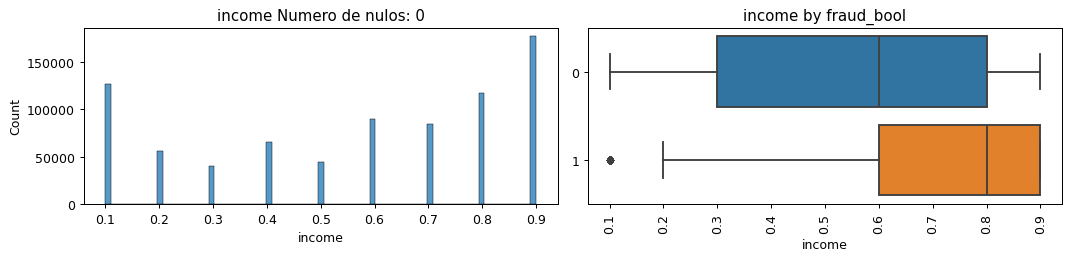

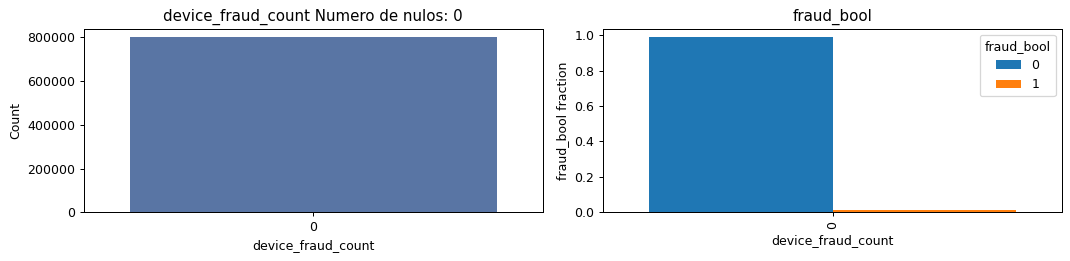

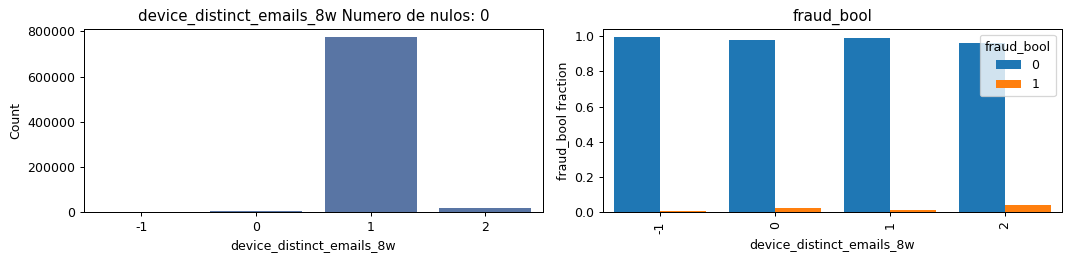

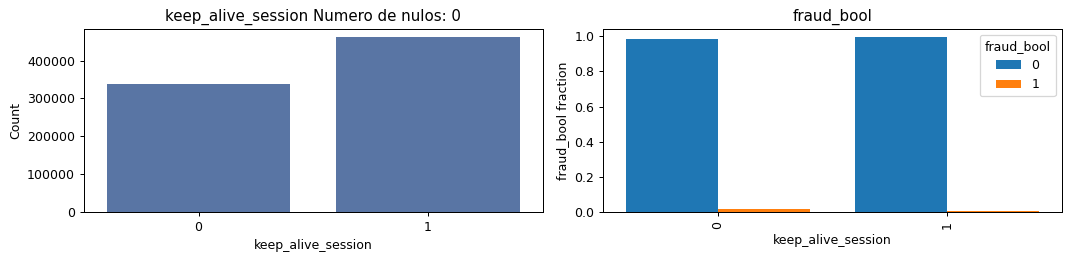

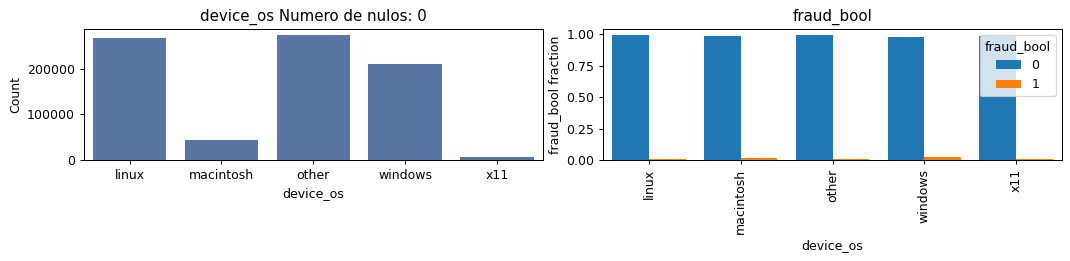

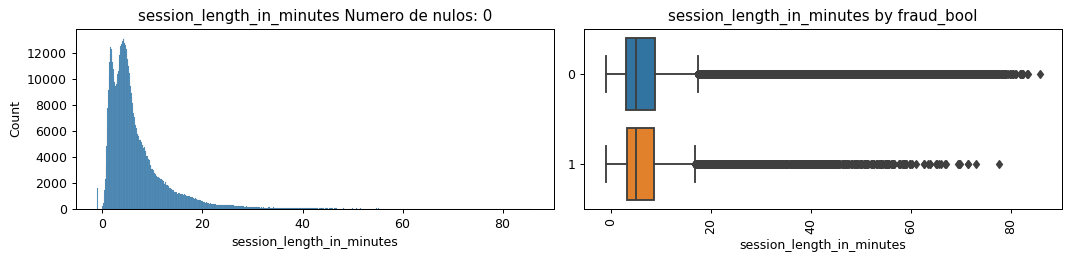

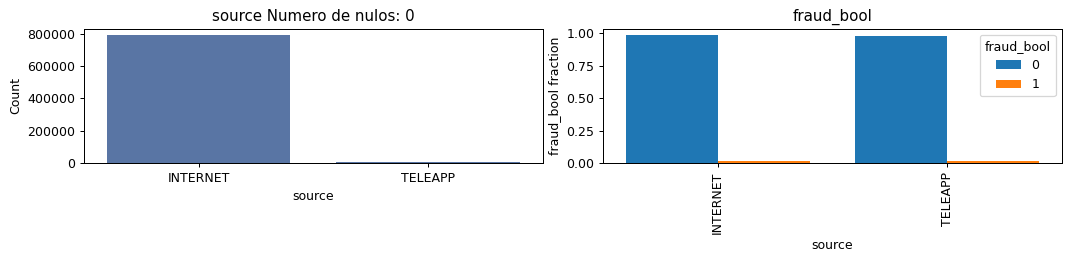

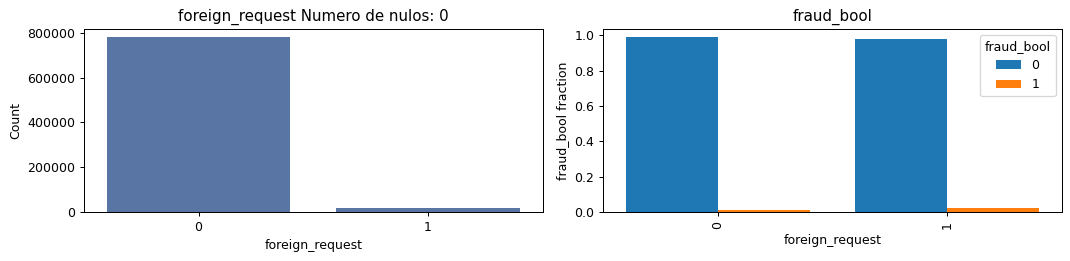

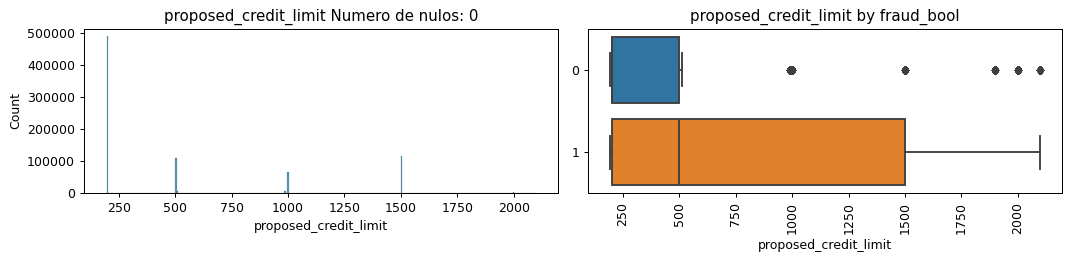

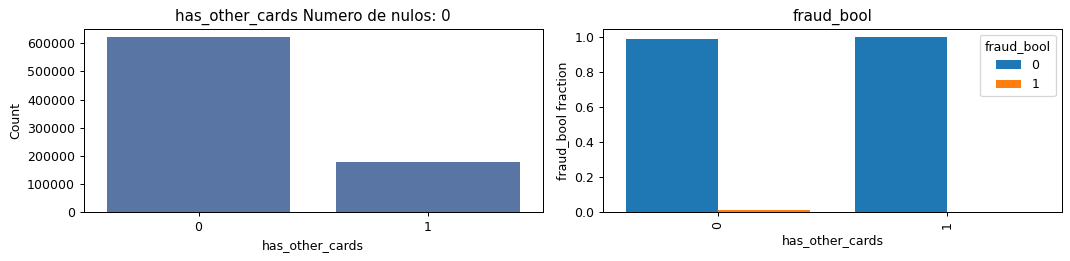

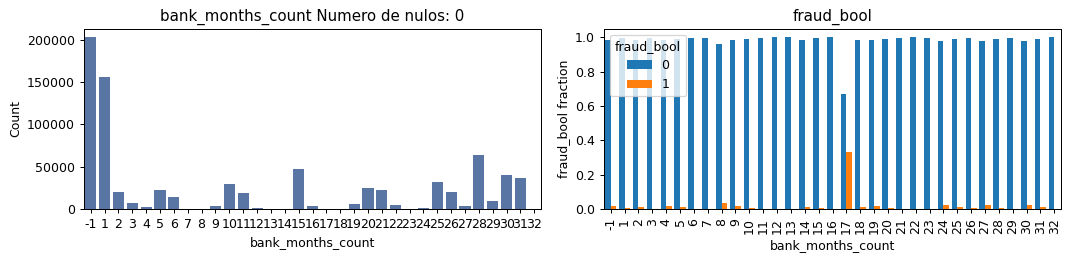

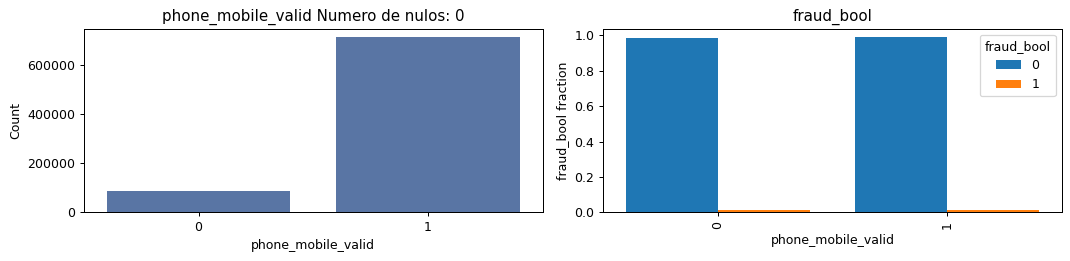

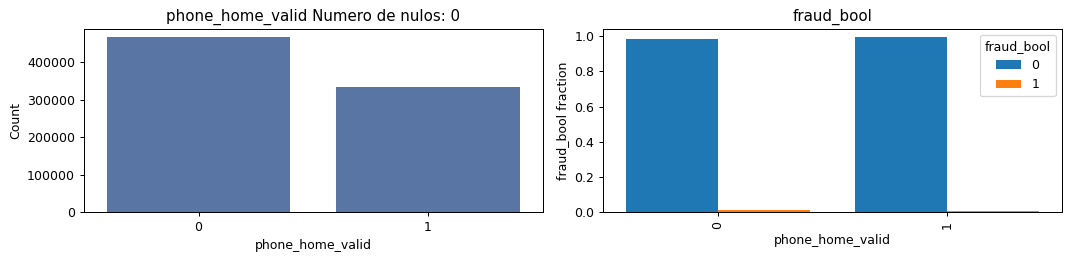

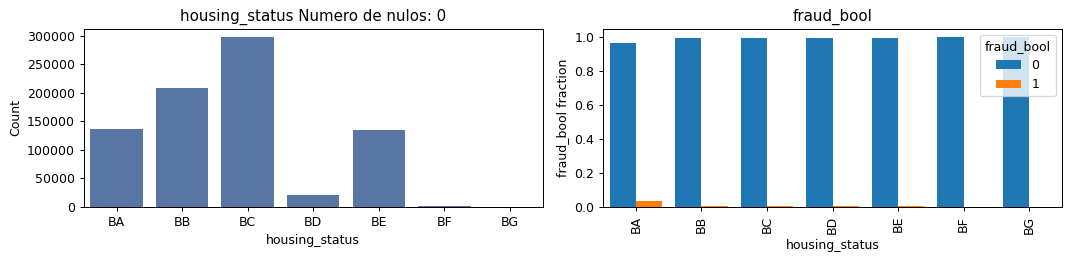

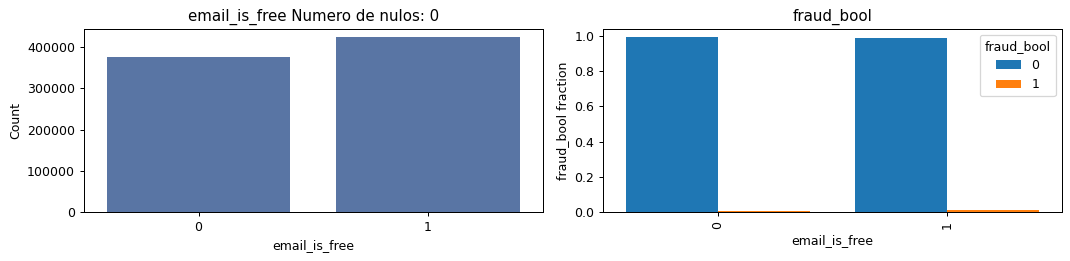

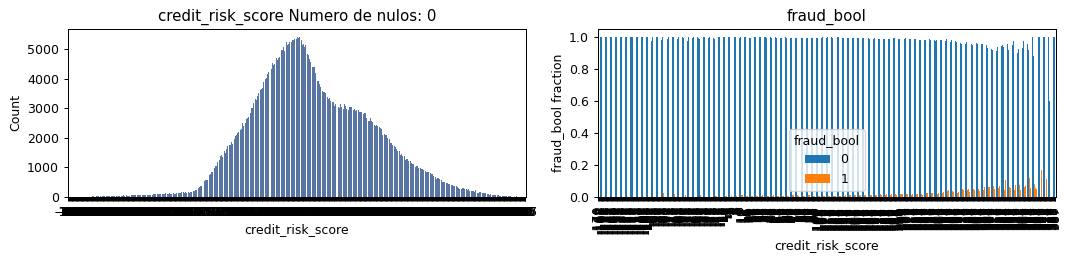

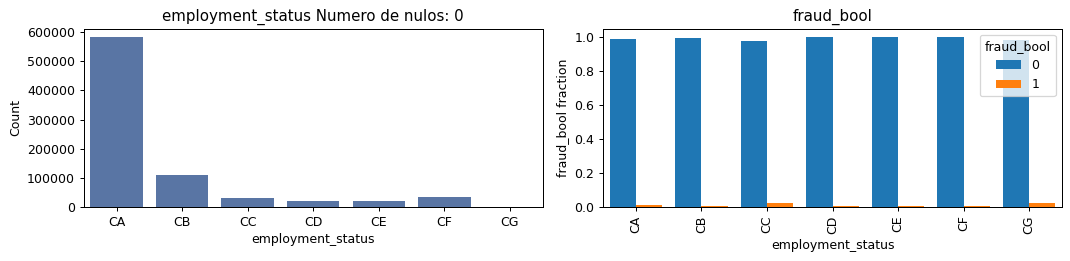

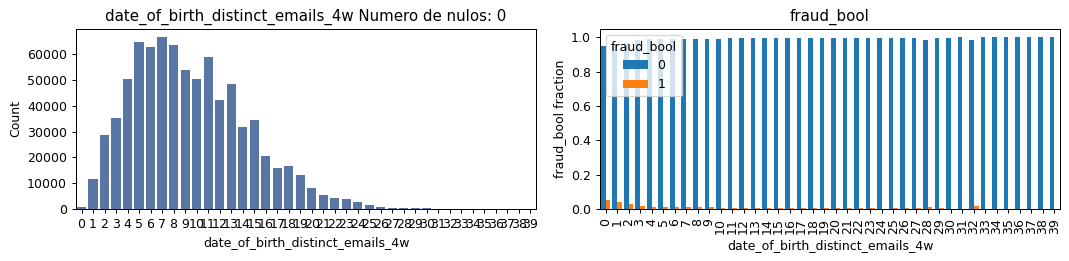

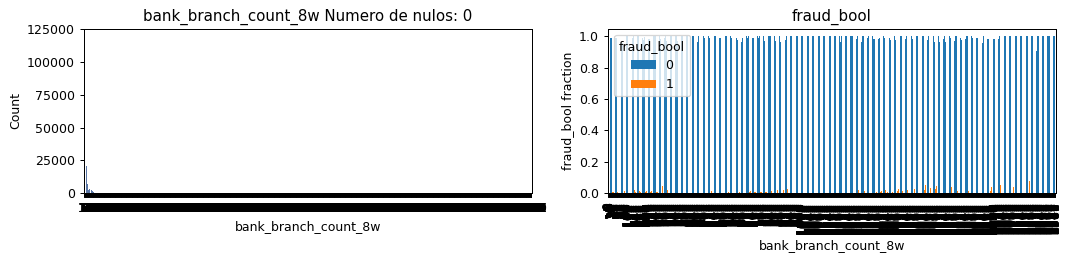

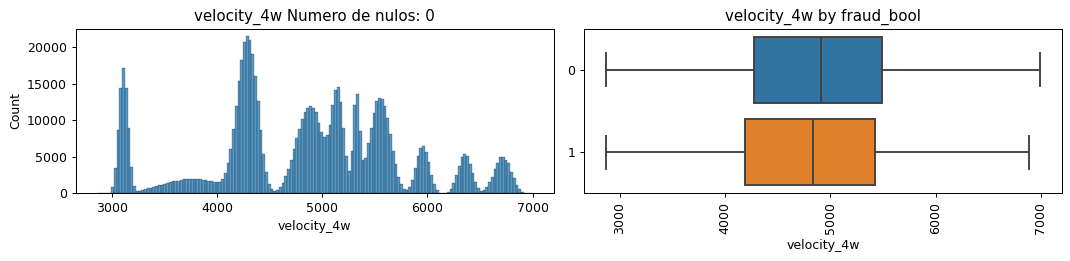

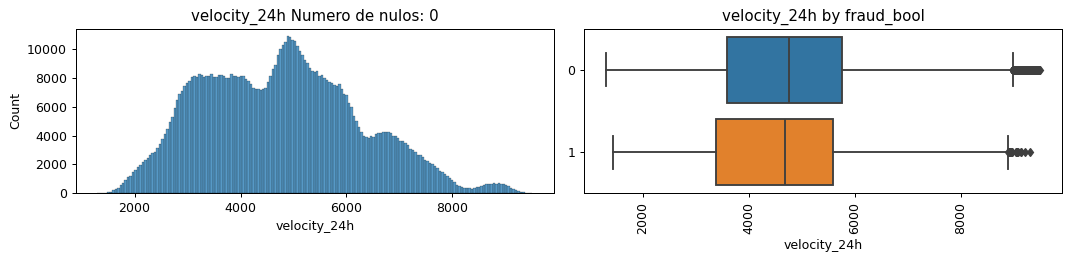

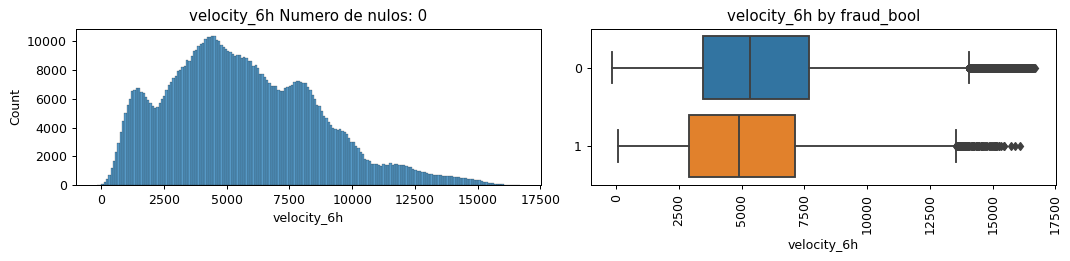

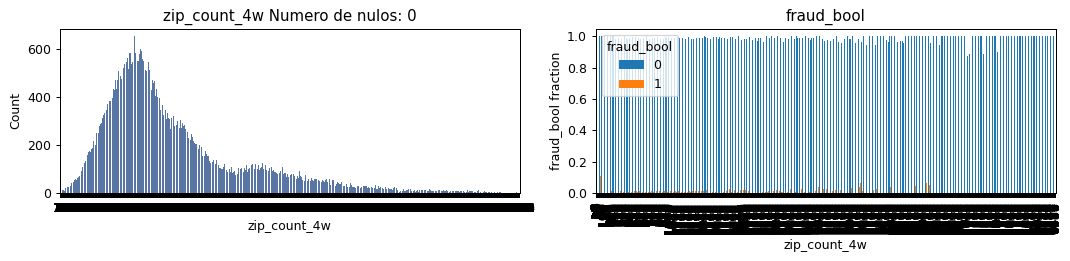

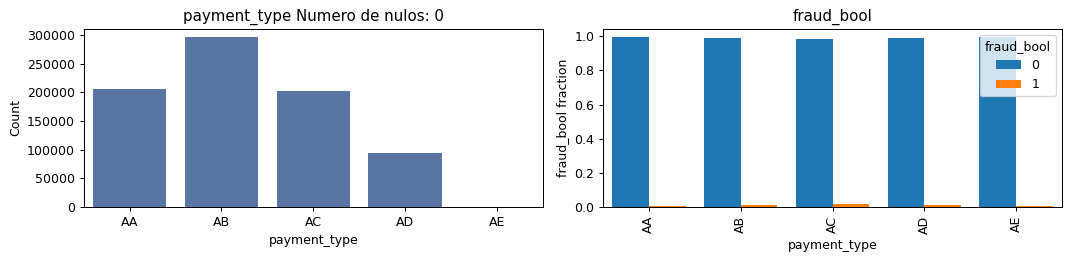

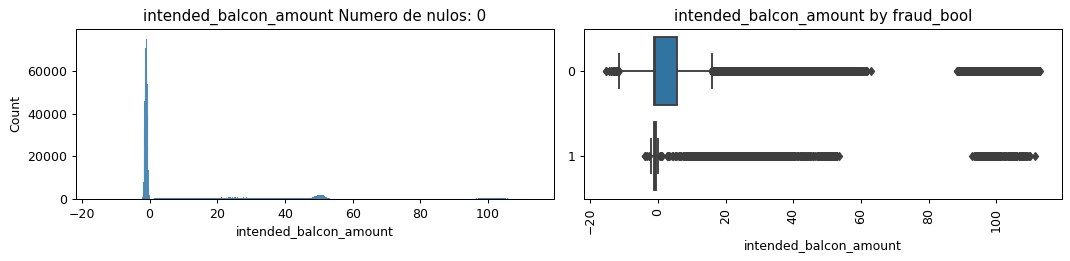

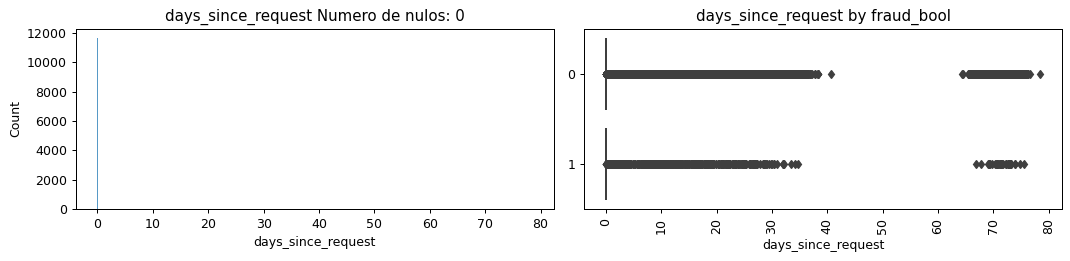

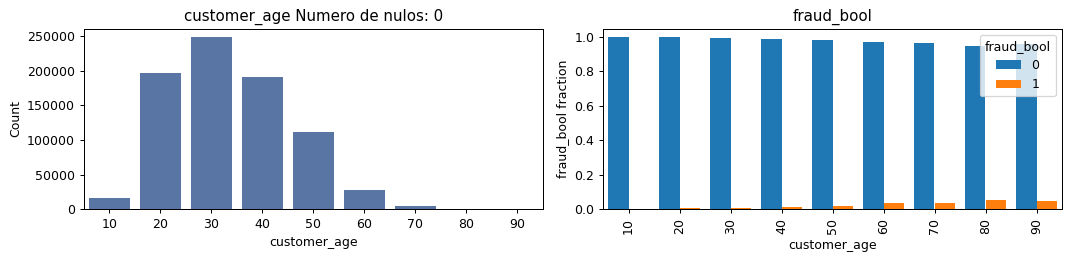

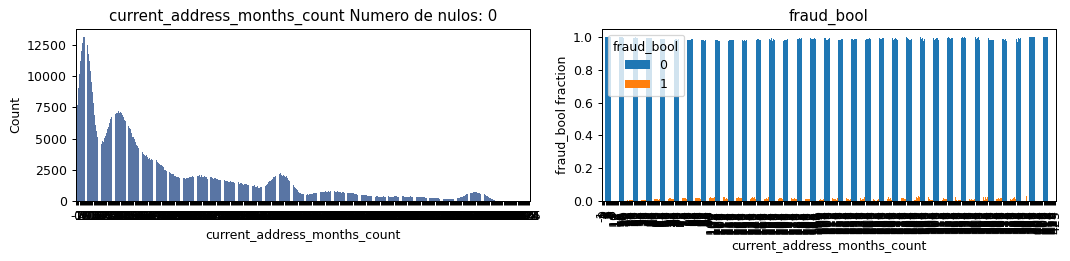

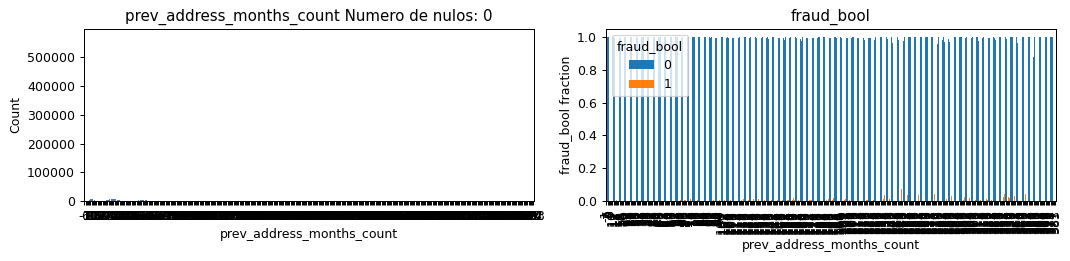

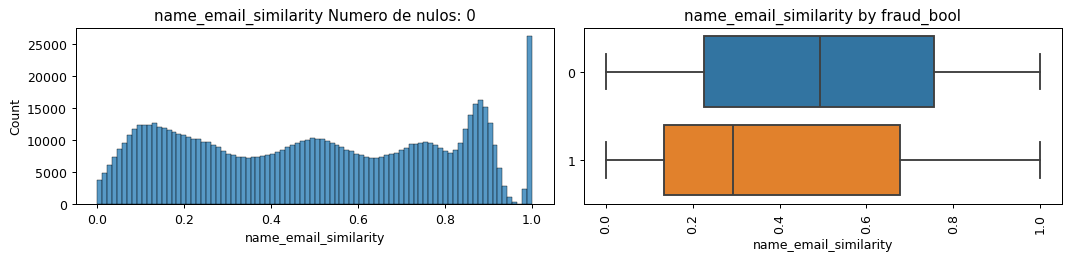

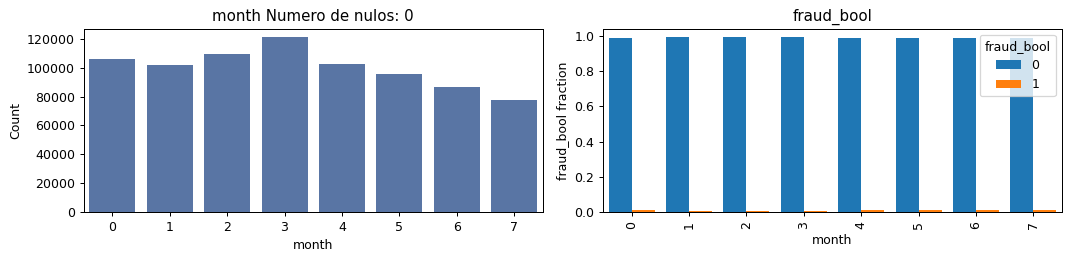

In [26]:
warnings.filterwarnings('ignore')
for i in list(pd_fraud_train.columns):
    if (pd_fraud_train[i].dtype==float) & (i!='fraud_bool'):
        plot_feature(pd_fraud_train, col_name=i, isContinuous=True, target='fraud_bool')
    elif  i!='fraud_bool':
        plot_feature(pd_fraud_train, col_name=i, isContinuous=False, target='fraud_bool')

Vamos a comentar ahora los gráficos que nos aportan información mas relevante:

En el BoxPlot "income by fraud bool" podemos ver que las cuentas fraudulentas 
tienen una menor dispersión y que además la mediana en income es superior. Esto parece indicar que las cuentas que realizan 
fraude son aquellas con más income.

En el gráfico en el que se compara la variable "fraud_bool" con la variable "customer age" podemos observar que a medida que el 
rango de edad aumenta hay un fraude mayor, por lo que debería ser un factor a tener en cuenta.

Comparando el "name_email_similarity" se puede observar que cuando hacen fraude la similitud del email y del nombre del aplicante es menor que cuando no lo hacen.

En el gráfico "proposed_credir_limit by fraud bool" sugiere que en los casos de fraude los límites de crédito propuestos son 
más altos y con una mayor variabilidad en estos límites en comparación con los casos no fraudulentos. 
Sin embargo, hay ciertos casos no fraudulentos que tienen límites de crédito propuestos extremadamente altos, como lo indican
los valores atípicos.

En el gráfico que compara "fraud bool" con "has_another card" lo que podemos observar es que todos los casos de fraude 
observados en este conjunto de datos están asociados con individuos que no poseen otras tarjetas.

Comparando "fraud_bool" con "device_os" se observa que Windows es el sistema operativo en el que se realiza más fraude.

Al comparar "fraud_bool" con "device_disticnt_emails_8w" se puede ver que cuando hay 2 correos electrónicos distintos,
hay una pequeña proporción de fraude, aunque sigue siendo bastante baja en comparación con la cantidad de casos no fraudulentos.

Al comparar la antigüedad de las cuentas podemos observar que cuando las cuentas tienen una antigüedad de 17 meses el número
de operaciones fraudulentas sube considerablemente, por lo que es un factor importante a tener en cuenta y a investigar.

El tiempo que pasan los usuarios en la página web del banco no es representativo de si se va a efectuar fraude o no.

En el boxplot que relaciona "intended_balcon_amount" con  "fraud_bool" podemos observar que en los casos de fraude la cantidad
que suelen ingresar al principio los aplicantes es menor que cuando no hay fraude. Además,en el grupo '1', hay menos puntos atípicos, lo que podría sugerir que las transacciones fraudulentas no suelen tener cantidades extremadamente altas o bajas.

Con esta funcion elaboramos un dataframe que nos diga el numero de outliers que hay en cada variable presente en la lista
"list_var_continuous" y el porcentaje de outliers en relacion a la cantidad total de datos en cada columna.

In [27]:
get_deviation_of_mean_perc(pd_fraud_train, list_var_continuous, "fraud_bool", 3)


,0,1,variable,sum_outlier_values,porcentaje_sum_null_values
0,0.980611,0.019389,session_length_in_minutes,18774,0.023467
1,0.870085,0.129915,proposed_credit_limit,4934,0.006168
2,0.995455,0.004545,velocity_24h,440,0.000550
3,0.993457,0.006543,velocity_6h,3515,0.004394
4,0.990827,0.009173,intended_balcon_amount,15153,0.018941
5,0.988173,0.011827,days_since_request,14289,0.017861


Podemos observar que no son cantidades representativas,el mayor porcentaje es 2,3% . Sin embargo en función del tipo
de modelo que escojamos decidiremos que hacer con estos atípicos debido a que algunos modelos son más sensibles a los
datos atípicos que otros. Además los outliers pueden contener información muy valiosa en ocasiones.

Por ejemplo, en nuestro caso,en la detección de fraude , los outliers pueden ser precisamente los casos que se quieren
identificar. Por ello, a la hora de realizar el modelo decidiremos que hacer con estos datos.

Aquí lo que queremos comprobar es las correlaciones que existen entre las distintas varibles continuas.

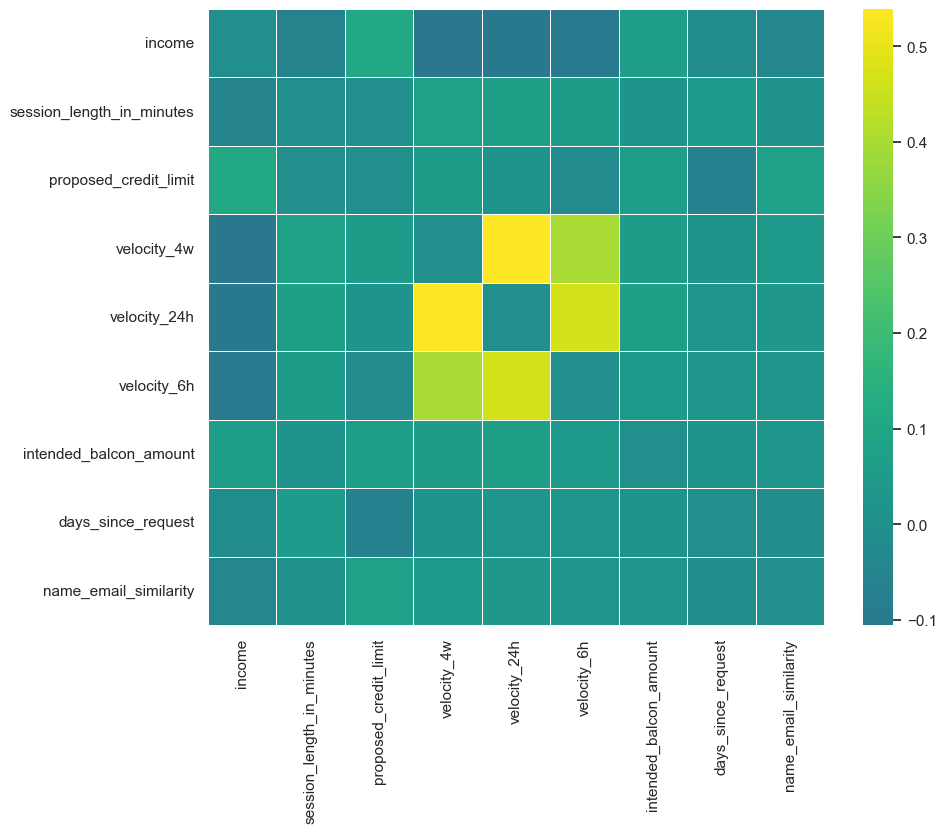

0

In [28]:
get_corr_matrix(dataset = pd_fraud_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

Tal y como podemos observar las correlaciones entre las variables continuas no son del todo fuertes. 
La máxima correlacion que hay se encuentra en torno a 0,5 lo que nos indica, en el contexto práctico,
que la correlacion es significativa y hay una asociación notable entre las variables, 
pero no lo suficientemente fuerte como para indicar que un cambio en una variable predecirá con alta precisión
un cambio en la otra.

Destacar que la diagonal es 0 y no 1 porque se ha especificado así en la función para posteriormente al filtrar
evitar ver los 1 que son de la variable consigo misma.

In [29]:
corr = pd_fraud_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

,level_0,level_1,correlation
39,velocity_24h,velocity_4w,0.53911


Aquí indentificamos y ordenamos todas las correlaciones fuertes (mayores de 0.5 en valor absoluto) entre las variables
continuas del conjunto de datos de entrenamiento, lo cual es útil para comprobar que lo que interpretamos en el gráfico
de arriba visualmente es correcto y entender poder fijarnos en las dependencias más fuertes que haya entre las variables.

Con esta función podemos comprobar si hay valores missing.En este caso nos dice que no, pero en nuestro dataset los missings
se representan de una manera distinta por lo que en realidad si que hay missings.
Esos missing ya han sido cuantificados con anterioridad por lo que proseguimos el análisis.
Esta función es de gran ayuda para cuando los missing se presentan como NaN.

In [30]:
get_percent_null_values_target(pd_fraud_train, list_var_continuous, target='fraud_bool')

No existen variables con valores nulos


""


Payment type: Podemos observar que cuando hay más fraude es con el tipo de pago AC y que segun el índice de Cramér sugiere que
hay una asociacion muy baja entre el tipo de pago y si la asocación es fraudulenta o no.

Employment_status: Cuando el employment_status es CA hay más fraude , sin embargo la asociación entre las variables
sigue siendo debil.

Housing_status: Podemos observar que cuando el housing status es BG no existe fraude. Asociación débil.

Email_is_free: el tipo de email (gratuito o no) no es un indicador fuerte o decisivo de fraude en las transacciones.

Phone_home_valid y phone_mobile_valid: Se puede observar que la mayoria de fraude tiene lugar cuando no se da el número
de teléfono de casa pero si el teléfono móvil.Sin embargo el índice cramer es muy bajo.

Has_other_cards:Se puede observar que cuando hay fraude la mayoria de usuarios que lo realizan no tienen otra tarjeta de 
crédito. Sin embargo según el índice de cramer se puede ver que  conocer el valor de una variable no proporciona mucha 
información sobre el valor de la otra.

Device_os: No hay practicamente relacion entre las variables. Eso si, la mayoria de fraude viene de usuarios de Windows.

Source: La mayoria de fraude tiene lugar a traves de INTERNET, aunque tambien es verdad que la gran mayoria de usuarios
proceden de Internet.

In [31]:
for var in lista_variables_categoricas:
    confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train[var])
    print(f"Matriz de confusión para {var}:")
    print(confusion_matrix)
    print(f"Valor de Cramér's V para {var}: {cramers_v(confusion_matrix.values)}")
    print("\n") 

Matriz de confusión para payment_type:
payment_type      AA      AB      AC     AD   AE
fraud_bool                                      
0             205352  293121  198313  94154  237
1               1075    3367    3373   1007    1
Valor de Cramér's V para payment_type: 0.039413919158339535


Matriz de confusión para employment_status:
employment_status      CA      CB     CC     CD     CE     CF   CG
fraud_bool                                                        
0                  576989  109686  29484  21304  18231  35138  345
1                    7112     761    751     79     43     70    7
Valor de Cramér's V para employment_status: 0.03975732747754006


Matriz de confusión para housing_status:
housing_status      BA      BB      BC     BD      BE    BF   BG
fraud_bool                                                      
0               130613  207633  295811  20774  134796  1354  196
1                 5099    1237    1829    179     476     3    0
Valor de Cramér's V para

In [32]:
pd_fraud_train.to_csv("../data/train_pd_data_preprocessing_missing_outlier.csv")

In [33]:
pd_fraud_test.to_csv("../data/test_pd_data_preprocessing_missing_outlier.csv")